In [ ]:
!pip install deepxde
import deepxde as dde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.3 MB/s eta 0:00:00
No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



#Dependencies

In [ ]:

import numpy as np
import scipy as sp

from scipy.interpolate import griddata
import matplotlib
import matplotlib.pyplot as plt


#Inverse Problem Without noise

In [ ]:
#Define the Spatial and temporal domains
L=1 #Lenght of the bar
final_time = 2 #Measurement time

geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, final_time)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Anchors for the final time, used to sample temperature data at random points along the bar,
# which could also be evenly spaced.
sampler = sp.stats.qmc.Sobol(d=1, scramble=True, seed=42)  # Sobol sequence for quasi-random sampling
n_rand = 256
x = sampler.random(n_rand) * L  # Random points with x ∈ (0,1)

tf = np.vstack(np.ones(n_rand) * final_time)  # Column of final_time values
anchors_tf = np.concatenate((x, tf), axis=1)  # Combine x and tf into (x, tf) pairs


# Problem parameters:
a = 0.01  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditionsd

# Define the exact solution of the heat equation for comparison at t = tf
def heat_eq_exact_solution(X):

    x = X[:, 0:1]  # Spatial coordinates (x)
    t = X[:, 1:2]  # Time values (t)

    # Return the exact solution for sinusoidal initial conditions
    # Parameters:
    # X : np.ndarray, shape (N,2) - Array with x (spatial) and t (time) values

    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)

def pde(x, y):
    """Computes the residual of the heat equation PDE."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)  # Time derivative of y
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)  # Second spatial derivative of y
    return dy_t - a * dy_xx  # Heat equation residual


#Boundary conditions
def boundary_tf(x,_):
    #Checks if the temporal point x[1] is close to the boundary at t = 3
    return np.isclose(x[1], final_time)

# Define a periodic boundary condition (for spatial periodicity on boundaries)
bc_periodic = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)

# Define a condition representing measurements at the final time, treated as an "initial condition" at t = tf
# This uses the exact solution on the temporal boundary at the final time.
ic_tf = dde.icbc.IC(geomtime, heat_eq_exact_solution, boundary_tf)

# Define the PDE problem data setup, including boundary conditions, initial conditions, and sampling points
data = dde.data.TimePDE(
    geomtime,  # Time and spatial geometry of the problem
    pde,  # The residual function representing the heat equation PDE
    [bc_periodic, ic_tf],  # Boundary conditions (periodic) and initial condition at the final time
    num_domain=2540,  # Number of interior points in the domain for the data generation
    num_boundary=256,  # Number of boundary points for applying the boundary conditions
    num_initial=0,  # No initial condition points are used (since final time is the condition)
    solution=heat_eq_exact_solution,  # Exact solution used for comparison and validation
    num_test=None,  # No separate test points for validation due to a bug when used with anchors
    anchors=anchors_tf  # Points sampled at the final time for data generation
)

# Define a fully connected neural network with 2 input neurons, 6 hidden layers of 200 neurons each, and 1 output neuron
layer_size = [2] + [200] * 6 + [1]  # Layer structure: 2 input neurons, 6 hidden layers with 200 neurons, 1 output neuron
activation = "tanh"  # Activation function for the hidden layers (tanh)
initializer = "Glorot uniform"  # Weight initialization method (Glorot uniform)
net = dde.nn.FNN(layer_size, activation, initializer)  # Initialize the neural network

# Define and compile the model using the previously defined data and neural network
model = dde.Model(data, net)  # Create the model with the PDE data and neural network

# Compile the model with the Adam optimizer, learning rate, metrics, and decay configuration
model.compile(
    "adam",  # Optimizer: Adam
    lr=0.001,  # Learning rate for the optimizer
    metrics=["l2 relative error"],  # Metric to evaluate the model's performance during training
    decay=("inverse time", 3000, 0.9)  # Learning rate decay strategy (inverse time decay with given parameters)
)

# Train the model for 20,000 epochs, capturing the loss history and training state
losshistory, train_state = model.train(epochs=20000)


Compiling model...
Building feed-forward neural network...
'build' took 0.407515 s

'compile' took 2.945334 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.20e-03, 5.45e-04, 2.81e-01]    [1.20e-03, 5.45e-04, 2.81e-01]    [9.59e-01]    
1000      [1.88e-03, 1.69e-03, 1.42e-03]    [1.88e-03, 1.69e-03, 1.42e-03]    [9.77e-02]    
2000      [6.92e-04, 1.33e-03, 8.46e-04]    [6.92e-04, 1.33e-03, 8.46e-04]    [7.32e-02]    
3000      [1.70e-04, 2.68e-05, 1.06e-04]    [1.70e-04, 2.68e-05, 1.06e-04]    [3.43e-02]    
4000      [2.56e-04, 1.46e-04, 6.66e-05]    [2.56e-04, 1.46e-04, 6.66e-05]    [3.05e-02]    
5000      [2.19e-05, 2.36e-06, 1.24e-05]    [2.19e-05, 2.36e-06, 1.24e-05]    [1.36e-02]    
6000      [1.23e-05, 8.73e-07, 7.11e-06]    [1.23e-05, 8.73e-07, 7.11e-06]    [1.16e-02]    
7000      [1.27e-05, 5.30e-06, 2.09e-05]    [1.27e-05, 5.30e-06, 2.09e-05]    [1.64e-02]    
8000      [6.22e-06, 3.23e-07, 3.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


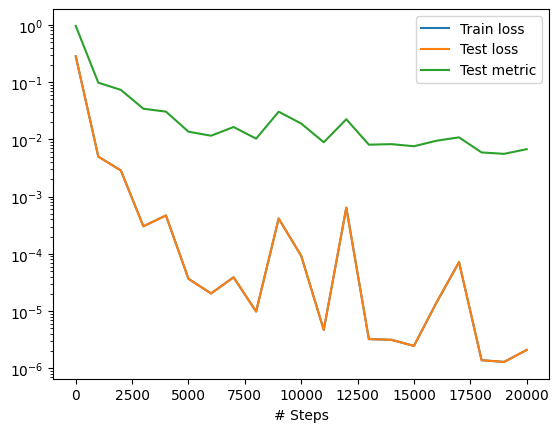

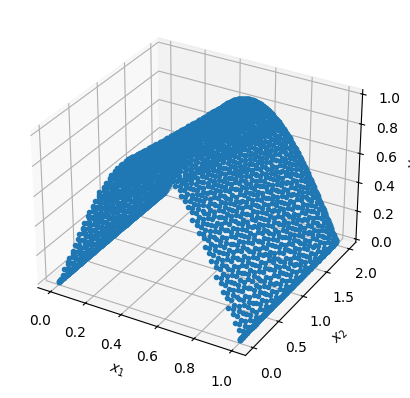

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
from scipy.interpolate import griddata
import matplotlib
import matplotlib.pyplot as plt


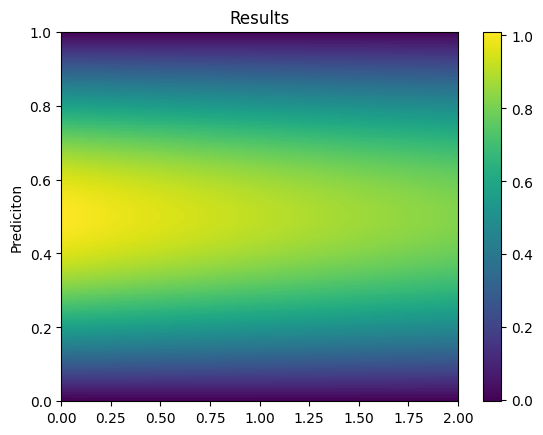

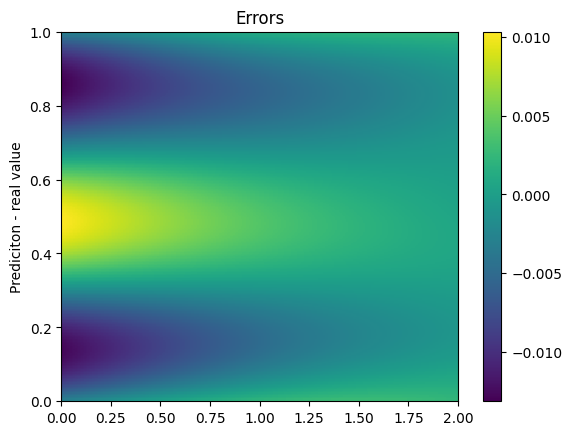

In [ ]:
    #Ploting results
    x = np.linspace(0, L, 256)
    t = np.linspace(0, final_time, 256)
    #m= np.ones(65536)*i
    #m=m.reshape(-1,1)
    #m=np.vstack(m)

    X, T = np.meshgrid(x, t)

    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    #x1,t1=np.split(X_star, 2, axis=1)
    #X_star_m= np.concatenate((x1,m,t1), axis=1)

    prediction = model.predict(X_star, operator=None)

    v = griddata(X_star, prediction[:, 0], (X, T), method="cubic")

    fig, ax = plt.subplots()
    ax.set_title("Results")
    ax.set_ylabel("Prediciton")
    ax.imshow(
        v.T,
        interpolation="nearest",
        cmap="viridis",
        extent=[0, final_time, 0, L],
        origin="lower",
        aspect="auto",
    )
    fig.colorbar(plt.cm.ScalarMappable(matplotlib.colors.Normalize(prediction.min(),prediction.max()), cmap="viridis"), ax=ax)
    plt.show()


    x = np.linspace(0, L, 256)
    t = np.linspace(0, final_time, 256)
    #m= np.ones(65536)*i
    #m=m.reshape(-1,1)
    #m=np.vstack(m)

    X, T = np.meshgrid(x, t)

    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

    prediction = model.predict(X_star, operator=None)
    real=heat_eq_exact_solution(X_star)
    prediction=prediction-real
    #prediction=np.sqrt(prediction*prediction)


    v_sol = griddata(X_star, prediction[:, 0], (X, T), method="cubic")

    fig, ax = plt.subplots()
    ax.set_title("Errors")
    ax.set_ylabel("Prediciton - real value")
    ax.imshow(
        v_sol.T,
        interpolation="nearest",
        cmap="viridis",
        extent=[0, final_time, 0, L],
        origin="lower",
        aspect="auto",
    )
    fig.colorbar(plt.cm.ScalarMappable(matplotlib.colors.Normalize(prediction.min(),prediction.max()), cmap="viridis"), ax=ax)
    plt.show()

    v_sol = griddata(X_star, real[:, 0], (X, T), method="cubic")



In [ ]:
x_value=np.linspace(0, L, 256)
x_value = np.reshape(x_value, np.shape(v[0]))

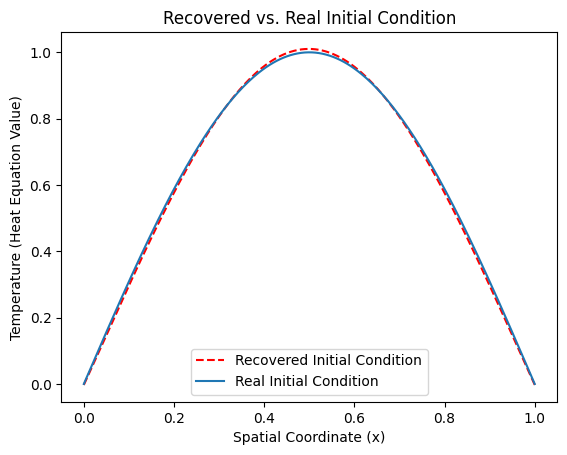

In [ ]:
# Plot recovered vs. real initial condition
plt.plot(x_value, v[0], label="Recovered Initial Condition", color='red', linestyle='--')  # Dashed red line for prediction
plt.plot(x_value, v_sol[0], label="Real Initial Condition")
plt.xlabel("Spatial Coordinate (x)")  # X-axis represents the length of the bar
plt.ylabel("Temperature (Heat Equation Value)")  # Y-axis represents the temperature
plt.title("Recovered vs. Real Initial Condition")  # Add title
plt.legend()
plt.show()


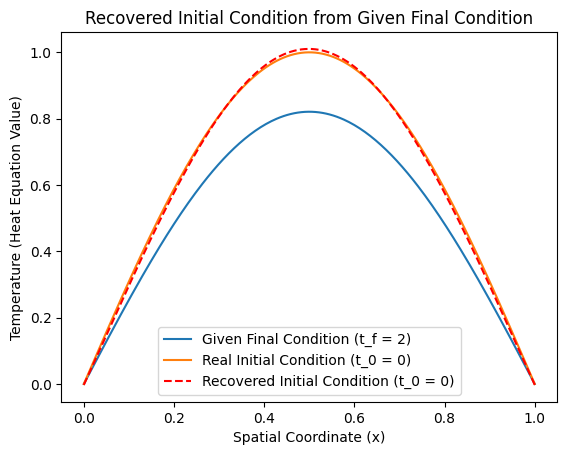

In [ ]:
# Plot recovered vs. real initial condition
plt.plot(x_value, v_sol[-1], label="Given Final Condition (t_f = 2)")
plt.plot(x_value, v_sol[0], label="Real Initial Condition (t_0 = 0)")
plt.plot(x_value, v[0], label="Recovered Initial Condition (t_0 = 0)", color='red', linestyle='--')  # Dashed red line for prediction
plt.xlabel("Spatial Coordinate (x)")  # X-axis represents the length of the bar
plt.ylabel("Temperature (Heat Equation Value)")  # Y-axis represents the temperature
plt.title("Recovered Initial Condition from Given Final Condition")
plt.legend()
plt.show()


#Inverse problem with noise

In [ ]:
import numpy as np

def heat_eq_exact_solution_with_noise_01(X):
    # Generate datasets with noise with v_taxa = 0.01
    x = X[:, 0:1]  # Spatial coordinates (x)
    t = X[:, 1:2]  # Time values (t)

    # Exact solution
    u_sol = np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)

    # Add noise with v_taxa = 0.01
    np.random.seed(42)
    rand = np.random.normal(loc=0, scale=1, size=u_sol.shape)
    u_sol_with_noise = u_sol * (1 + 0.01 * rand)

    return u_sol_with_noise

def heat_eq_exact_solution_with_noise_05(X):
    # Generate datasets with noise with v_taxa = 0.05
    x = X[:, 0:1]  # Spatial coordinates (x)
    t = X[:, 1:2]  # Time values (t)

    # Exact solution
    u_sol = np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)

    # Add noise with v_taxa = 0.05
    np.random.seed(42)
    rand = np.random.normal(loc=0, scale=1, size=u_sol.shape)
    u_sol_with_noise = u_sol * (1 + 0.05 * rand)

    return u_sol_with_noise

def heat_eq_exact_solution_with_noise_10(X):
    # Generate datasets with noise with v_taxa = 0.10
    x = X[:, 0:1]  # Spatial coordinates (x)
    t = X[:, 1:2]  # Time values (t)

    # Exact solution
    u_sol = np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)

    # Add noise with v_taxa = 0.10
    np.random.seed(42)
    rand = np.random.normal(loc=0, scale=1, size=u_sol.shape)
    u_sol_with_noise = u_sol * (1 + 0.10 * rand)

    return u_sol_with_noise


In [ ]:
import deepxde as dde
import numpy as np
import scipy as sp

#Define the Spatial and temporal domains
L=1 #Lenght of the bar
final_time = 2 #Measurement time

geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, final_time)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Anchors for the final time, used to sample temperature data at random points along the bar,
# which could also be evenly spaced.
sampler = sp.stats.qmc.Sobol(d=1, scramble=True, seed=42)  # Sobol sequence for quasi-random sampling
n_rand = 256
x = sampler.random(n_rand) * L  # Random points with x ∈ (0,1)

tf = np.vstack(np.ones(n_rand) * final_time)  # Column of final_time values
anchors_tf = np.concatenate((x, tf), axis=1)  # Combine x and tf into (x, tf) pairs


# Problem parameters:
a = 0.01  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditionsd

# Define the exact solution of the heat equation for comparison at t = tf
def heat_eq_exact_solution(X):

    x = X[:, 0:1]  # Spatial coordinates (x)
    t = X[:, 1:2]  # Time values (t)

    # Return the exact solution for sinusoidal initial conditions
    # Parameters:
    # X : np.ndarray, shape (N,2) - Array with x (spatial) and t (time) values

    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)


def pde(x, y):
    """Computes the residual of the heat equation PDE."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)  # Time derivative of y
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)  # Second spatial derivative of y
    return dy_t - a * dy_xx  # Heat equation residual


#Boundary conditions
def boundary_tf(x,_):
    #Checks if the temporal point x[1] is close to the boundary at t = 3
    return np.isclose(x[1], final_time)

# Define a periodic boundary condition (for spatial periodicity on boundaries)
bc_periodic = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)

# Define a condition representing measurements at the final time, treated as an "initial condition" at t = tf
# This uses the exact solution on the temporal boundary at the final time.
ic_tf = dde.icbc.IC(geomtime, heat_eq_exact_solution_with_noise_05, boundary_tf)

# Define the PDE problem data setup, including boundary conditions, initial conditions, and sampling points
data = dde.data.TimePDE(
    geomtime,  # Time and spatial geometry of the problem
    pde,  # The residual function representing the heat equation PDE
    [bc_periodic, ic_tf],  # Boundary conditions (periodic) and initial condition at the final time
    num_domain=2540,  # Number of interior points in the domain for the data generation
    num_boundary=256,  # Number of boundary points for applying the boundary conditions
    num_initial=0,  # No initial condition points are used (since final time is the condition)
    solution=heat_eq_exact_solution,  # Exact solution used for comparison and validation
    num_test=None,  # No separate test points for validation due to a bug when used with anchors
    anchors=anchors_tf  # Points sampled at the final time for data generation
)

# Define a fully connected neural network with 2 input neurons, 6 hidden layers of 200 neurons each, and 1 output neuron
layer_size = [2] + [200] * 6 + [1]  # Layer structure: 2 input neurons, 6 hidden layers with 200 neurons, 1 output neuron
activation = "tanh"  # Activation function for the hidden layers (tanh)
initializer = "Glorot uniform"  # Weight initialization method (Glorot uniform)
net = dde.nn.FNN(layer_size, activation, initializer)  # Initialize the neural network

# Define and compile the model using the previously defined data and neural network
model = dde.Model(data, net)  # Create the model with the PDE data and neural network

# Compile the model with the Adam optimizer, learning rate, metrics, and decay configuration
model.compile(
    "adam",  # Optimizer: Adam
    lr=0.001,  # Learning rate for the optimizer
    metrics=["l2 relative error"],  # Metric to evaluate the model's performance during training
    decay=("inverse time", 3000, 0.9)  # Learning rate decay strategy (inverse time decay with given parameters)
)

# Train the model for 20,000 epochs, capturing the loss history and training state
losshistory, train_state = model.train(epochs=20000)


Compiling model...
Building feed-forward neural network...
'build' took 0.157469 s

'compile' took 0.969765 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [9.91e-03, 7.36e-04, 1.76e-01]    [9.91e-03, 7.36e-04, 1.76e-01]    [8.69e-01]    
1000      [1.07e-03, 4.32e-05, 1.03e-03]    [1.07e-03, 4.32e-05, 1.03e-03]    [5.67e-02]    
2000      [3.21e-04, 3.14e-05, 7.56e-04]    [3.21e-04, 3.14e-05, 7.56e-04]    [3.82e-02]    
3000      [3.24e-04, 8.79e-04, 1.24e-03]    [3.24e-04, 8.79e-04, 1.24e-03]    [5.89e-02]    
4000      [3.02e-05, 2.93e-06, 7.16e-04]    [3.02e-05, 2.93e-06, 7.16e-04]    [1.97e-02]    
5000      [1.86e-05, 1.69e-06, 7.14e-04]    [1.86e-05, 1.69e-06, 7.14e-04]    [1.70e-02]    
6000      [1.38e-05, 1.18e-06, 7.11e-04]    [1.38e-05, 1.18e-06, 7.11e-04]    [1.46e-02]    
7000      [1.08e-05, 1.04e-06, 7.10e-04]    [1.08e-05, 1.04e-06, 7.10e-04]    [1.42e-02]    
8000      [8.92e-06, 6.63e-07, 7.

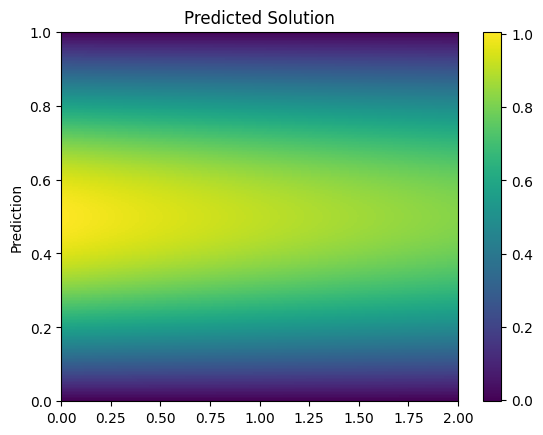

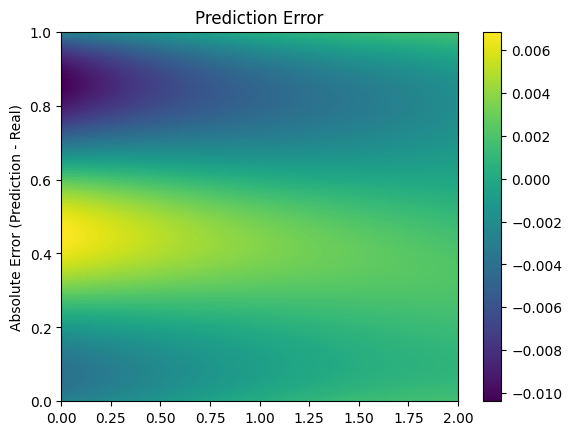

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.interpolate import griddata

# Generate spatial and temporal grids
x = np.linspace(0, L, 256)
t = np.linspace(0, final_time, 256)
X, T = np.meshgrid(x, t)

# Flatten and combine into X_star
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Model predictions
prediction = model.predict(X_star, operator=None)

# Compute exact solutions
real = heat_eq_exact_solution(X_star)
real_noised = heat_eq_exact_solution_with_noise_05(X_star)

# Compute absolute error
absolute_error = prediction - real

# Interpolating results for visualization
v_pred = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v_real = griddata(X_star, real[:, 0], (X, T), method="cubic")
v_real_noisy = griddata(X_star, real_noised[:, 0], (X, T), method="cubic")
v_error = griddata(X_star, absolute_error[:, 0], (X, T), method="cubic")

# Plot predicted values
fig, ax = plt.subplots()
ax.set_title("Predicted Solution")
ax.set_ylabel("Prediction")
img = ax.imshow(
    v_pred.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[0, final_time, 0, L],
    origin="lower",
    aspect="auto",
)
fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(v_pred.min(), v_pred.max()), cmap="viridis"), ax=ax)
plt.show()

# Plot error values
fig, ax = plt.subplots()
ax.set_title("Prediction Error")
ax.set_ylabel("Absolute Error (Prediction - Real)")
img = ax.imshow(
    v_error.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[0, final_time, 0, L],
    origin="lower",
    aspect="auto",
)
fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(v_error.min(), v_error.max()), cmap="viridis"), ax=ax)
plt.show()


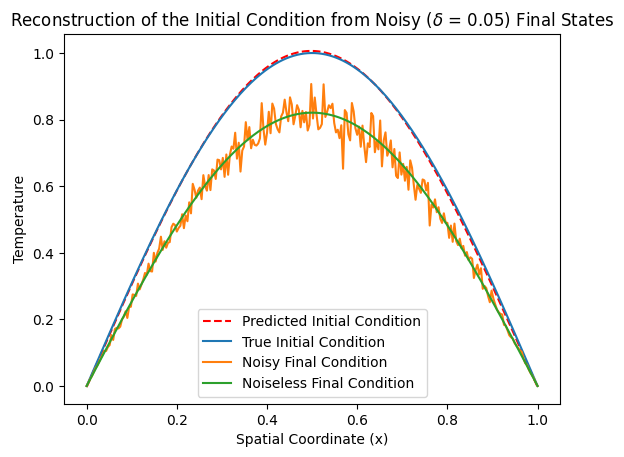

In [ ]:
import matplotlib.pyplot as plt

# Plot predicted vs. real initial conditions along with noised and noiseless final conditions
plt.plot(x_value, v[0], label="Predicted Initial Condition", color='red', linestyle='--')  # Dashed red line for prediction
plt.plot(x_value, v_sol[0], label="True Initial Condition")
plt.plot(x_value, v_sol_noised[-1], label="Noisy Final Condition")
plt.plot(x_value, v_sol[-1], label="Noiseless Final Condition")

# Labels and title
plt.xlabel("Spatial Coordinate (x)")  # X-axis represents the spatial domain
plt.ylabel("Temperature")  # Y-axis represents temperature
plt.title("Reconstruction of the Initial Condition from Noisy ($\delta$ = 0.05) Final States")  # Title for the plot

# Legend and display
plt.legend()
plt.show()


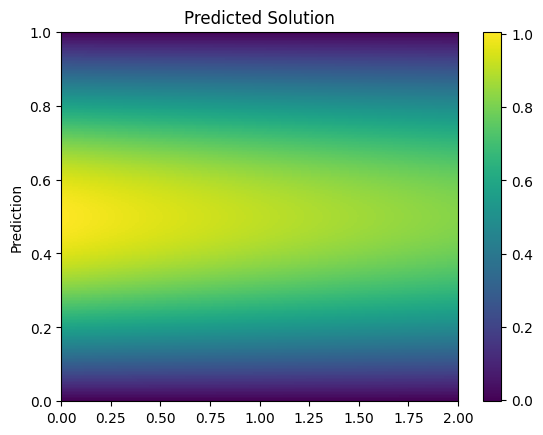

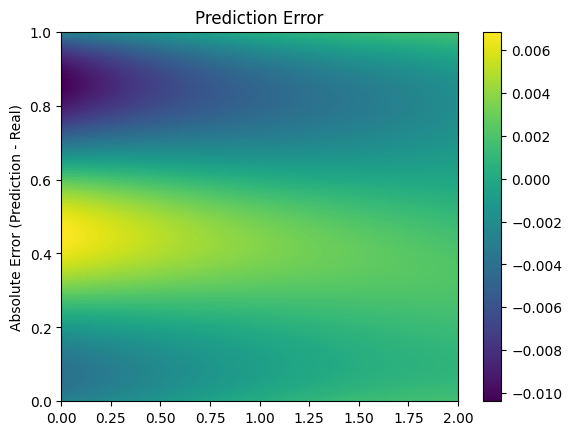

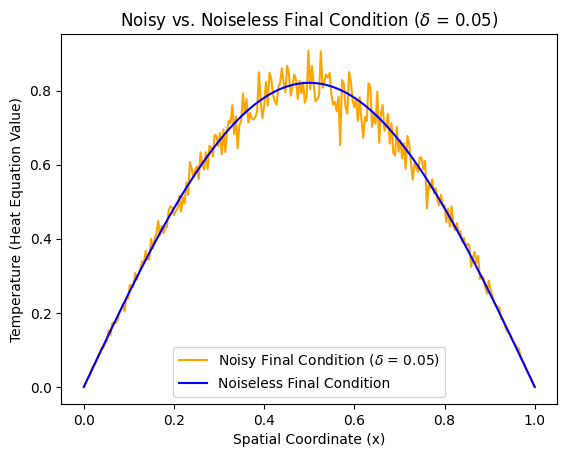

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.interpolate import griddata

# Generate spatial and temporal grids
x = np.linspace(0, L, 256)
t = np.linspace(0, final_time, 256)
X, T = np.meshgrid(x, t)

# Flatten and combine into X_star
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Model predictions
prediction = model.predict(X_star, operator=None)

# Compute exact solutions
real = heat_eq_exact_solution(X_star)
real_noised = heat_eq_exact_solution_with_noise_05(X_star)

# Compute absolute error
absolute_error = prediction - real

# Interpolating results for visualization
v_pred = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v_real = griddata(X_star, real[:, 0], (X, T), method="cubic")
v_real_noisy = griddata(X_star, real_noised[:, 0], (X, T), method="cubic")
v_error = griddata(X_star, absolute_error[:, 0], (X, T), method="cubic")

# Plot predicted values
fig, ax = plt.subplots()
ax.set_title("Predicted Solution")
ax.set_ylabel("Prediction")
img = ax.imshow(
    v_pred.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[0, final_time, 0, L],
    origin="lower",
    aspect="auto",
)
fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(v_pred.min(), v_pred.max()), cmap="viridis"), ax=ax)
plt.show()

# Plot error values
fig, ax = plt.subplots()
ax.set_title("Prediction Error")
ax.set_ylabel("Absolute Error (Prediction - Real)")
img = ax.imshow(
    v_error.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[0, final_time, 0, L],
    origin="lower",
    aspect="auto",
)
fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(v_error.min(), v_error.max()), cmap="viridis"), ax=ax)
plt.show()

# Plot noisy and noiseless final conditions with delta annotation
fig, ax = plt.subplots()
ax.set_title("Noisy vs. Noiseless Final Condition ($\delta$ = 0.05)")
ax.set_ylabel("Temperature")
ax.plot(x, v_real_noisy[-1], label="Noisy Final Condition ($\delta$ = 0.05)", color='orange')
ax.plot(x, v_real[-1], label="Noiseless Final Condition", color='blue')

# Labels and legend
plt.xlabel("Spatial Coordinate (x)")
plt.ylabel("Temperature (Heat Equation Value)")
plt.legend()

# Display plot
plt.show()
